In [20]:
import os
import tempfile
import numpy as np
import pyvista as pv 
import pyransac3d as pyrsc
import matplotlib.pyplot as plt

from tqdm import tqdm 
from joblib import Parallel, delayed
from sklearn.neighbors import KDTree
from sklearn.mixture import GaussianMixture

from utils.plot_tools import plot_pv, plot_gmm
from utils.las_tools import get_points_and_colors_from_las
from utils.statistical_tools import get_neighborhood, automatic_gmm_components, normalize_points

In [21]:
POOL_NAME = 'RBN'
PROJECT_NAME = 'pozas_110125_100_10_120'
PATH_PROJECT_LAS = f'data/{PROJECT_NAME}/{POOL_NAME}_col_0_row_1_19s.las'

LIMIT = 1_000_000
NEIGHBORHOOD_SIZE_R = 0.4

In [22]:
def process_chunk(chunk_indices, mmap_filename, shape, dtype, neighborhood_size_r):
    points = np.memmap(mmap_filename, dtype=dtype, mode='r', shape=shape)
    kdtree = KDTree(points[:,:2])
    chunk_results = []
    
    for i in chunk_indices:
        indices = get_neighborhood(kdtree, i, neighborhood_size_r)
        z_neighborhood = points[indices, 2]
        
        if len(z_neighborhood) < 2:
            continue
            
        z_neighborhood = z_neighborhood.reshape(-1, 1)
        optimal_n_components, _ = automatic_gmm_components(z_neighborhood, T=0.1)
        
        chunk_results.append([
            points[i, 0], 
            points[i, 1], 
            points[i, 2],
            points[i, 3],  
            points[i, 4], 
            points[i, 5], 
            optimal_n_components,
        ])
    
    return chunk_results

def get_points_with_optimal_n_components(points, neighborhood_size=0.1):
    
    # Configurar archivo temporal para memoria compartida
    temp_dir = tempfile.mkdtemp()
    mmap_filename = os.path.join(temp_dir, 'points.dat')
    fp = np.memmap(mmap_filename, dtype=points.dtype, mode='w+', shape=points.shape)
    fp[:] = points[:]
    del fp  # Liberar recursos y asegurar escritura
    
    # Configurar paralelización
    n_jobs = os.cpu_count()  # Usar todos los núcleos disponibles
    indices = np.arange(len(points))
    chunks = np.array_split(indices, n_jobs * 4)  # Dividir en más chunks para balanceo de carga
    
    # Procesar en paralelo
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_chunk)(
            chunk,
            mmap_filename,
            points.shape,
            points.dtype,
            neighborhood_size
        ) for chunk in tqdm(chunks, desc="Processing Chunks", position=0, leave=True) #chunks
    )
    
    # Limpiar y combinar resultados
    final_result = [item for sublist in results for item in sublist]
    
    # Limpiar archivos temporales
    try:
        os.remove(mmap_filename)
        os.rmdir(temp_dir)
    except Exception as e:
        print(f"Error limpiando archivos temporales: {e}")
    
    points_norm = np.array(final_result)
    points_, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(points_norm[:,:3])
    points_norm[:, :3] = points_
    
    return {
        'points_norm': points_norm,
        'x_min': x_min,
        'x_max': x_max,
        'y_min': y_min,
        'y_max': y_max,
        'z_min': z_min,
        'z_max': z_max
    }

## Estimate the number of Gaussians that fit for each point with respect to its height.

In [23]:
las_points, las_colors, las_rgba_colors = get_points_and_colors_from_las(PATH_PROJECT_LAS, limit=LIMIT)
las_points_colors = np.hstack((las_points, las_rgba_colors))
data_points = get_points_with_optimal_n_components(las_points_colors, neighborhood_size=NEIGHBORHOOD_SIZE_R) 

Processing Chunks:   0%|          | 0/64 [00:00<?, ?it/s][Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


Processing Chunks:  75%|███████▌  | 48/64 [06:04<02:24,  9.02s/it][Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  6.2min
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:  6.6min
Processing Chunks: 100%|██████████| 64/64 [09:27<00:00,  8.86s/it]
[Parallel(n_jobs=16)]: Done  40 out of  64 | elapsed:  9.9min remaining:  6.0min
[Parallel(n_jobs=16)]: Done  47 out of  64 | elapsed: 10.1min remaining:  3.6min
[Parallel(n_jobs=16)]: Done  54 out of  64 | elapsed: 13.3min remaining:  2.5min
[Parallel(n_jobs=16)]: Done  61 out of  64 | elapsed: 13.3min remaining:   39.4s
[Parallel(n_jobs=16)]: Done  64 out of  64 | elapsed: 13.4min finished


In [24]:
points_norm = data_points.get('points_norm', None)
points_one_component  = points_norm[np.where(points_norm[:,-1] == 1)][:,:-1]
points_two_component = points_norm[np.where(points_norm[:,-1] == 2)][:,:-1]

#plot_pv([points_one_component[:,:3], points_two_component[:,:3]],
#        ['blue', 'red'])

## Estimate the water surface for the points with two Gaussians

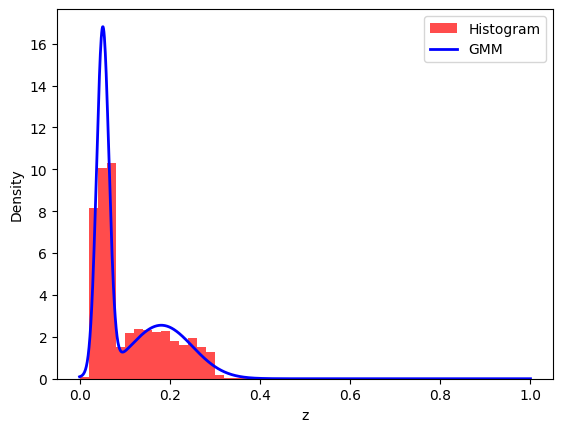

In [25]:
z_two_component = points_two_component[:,2]
gmm = GaussianMixture(n_components=2)
gmm.fit(z_two_component.reshape(-1, 1))

plot_gmm(z_two_component, gmm)

In [26]:
delta = 0.05
water_threshold = np.max(gmm.means_)

water_points = points_two_component[(z_two_component < water_threshold + delta) & (z_two_component >= water_threshold -delta)]
below_water = points_two_component[z_two_component < water_threshold - delta]
above_water  = points_two_component[z_two_component > water_threshold + delta]

#plot_pv([water_points, above_water, below_water],
#        ['blue', 'red', 'green'])


### Estimate the water plane with ransac

In [27]:
pv.global_theme.allow_empty_mesh = True

# Extraer las coordenadas x, y, z
X = points_two_component[:, 0]
Y = points_two_component[:, 1]
Z = points_two_component[:, 2]

 # Load your point cloud as a numpy array (N, 3)
plane1 = pyrsc.Plane()
best_eq, best_inliers = plane1.fit(water_points[:,:3], 0.01)

# Si deseas obtener la ecuación del plano en forma Ax + By + Cz + D = 0
A, B, C, D  = best_eq 
print(f"Ecuación del plano: {A}x + {B}y + {C}z + {D} = 0")

z_water = D if round(A) == 0 and round(B) == 0 and round(abs(C)) == 1 else -1e8

# Calcular la distancia de cada punto al plano
distances = (A * X + B * Y + C * Z + D) / np.sqrt(A**2 + B**2 + C**2)

# Crear una malla de puntos para el plano
xx, yy = np.meshgrid(np.linspace(X.min(), X.max(), 10), np.linspace(Y.min(), Y.max(), 10))
zz = (-A * xx - B * yy - D) / C

# # Crear una superficie para el plano
# plane = pv.StructuredGrid(xx, yy, zz)

# # Crear un plotter de PyVista
# plotter = pv.Plotter()

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -delta
above_plane = distances >= delta

# # Añadir los puntos por debajo del plano en rojo
# points_below = pv.PolyData(np.column_stack((X[below_plane], Y[below_plane], Z[below_plane])))
# plotter.add_points(points_below, color='red', point_size=5)

# # Añadir los puntos por encima del plano en azul
# points_above = pv.PolyData(np.column_stack((X[above_plane], Y[above_plane], Z[above_plane])))
# plotter.add_points(points_above, color='green', point_size=5)

# # Añadir la superficie del plano al plotter
# plotter.add_mesh(plane, color='blue', opacity=0.5)

# # Mostrar el plotter
# plotter.show()
print(z_water)

Ecuación del plano: 0.9298373287144065x + 0.0019598704689147077y + -0.3679656248034618z + -0.8369810479505605 = 0
-100000000.0


In [28]:
above_below = np.ma.mask_or(above_plane, below_plane, shrink=False)  

pool_points = points_two_component[above_below]
all_points = np.concatenate((points_one_component, pool_points), axis=0)

x = all_points[:, 0]
y = all_points[:,1]
z = all_points[:,2]

x = x * (data_points.get('x_max') - data_points.get('x_min'))
y = y * (data_points.get('y_max') - data_points.get('y_min'))
z = z * (data_points.get('z_max') - data_points.get('z_min')) 


# plt.title(f' {POOL_NAME} - Pool Undersurface')
# plt.scatter(x, y, c=z, cmap='viridis_r', s=0.02)
# plt.colorbar()
# plt.savefig(f'data/img/{POOL_NAME}_map_distance.png', dpi=300)
# plt.show()

In [29]:
import pandas as pd

points_one_component_s = np.hstack((points_one_component, np.full((points_one_component.shape[0], 1), 0)))
water_points_s = np.hstack((water_points, np.full((water_points.shape[0], 1), 1)))
below_water_s = np.hstack(( below_water, np.full((below_water.shape[0], 1), 2)))
above_water_s = np.hstack((above_water, np.full(( above_water.shape[0], 1), 3)))

all_points = np.concatenate((
    points_one_component_s,
    water_points_s,
    below_water_s, 
    above_water_s 
    ), axis=0)

df = pd.DataFrame(all_points, columns=['x', 'y', 'z', 'r', 'g', 'b', 'class'])
df.to_csv(f'data/{PROJECT_NAME}/{POOL_NAME}_zw_{z_water}.csv', index=False)
